## Reading the data

In [4]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt

df = pd.read_csv("../../corpus_sprint2_balanced_cp.csv", encoding="utf-8")
df = df.dropna()

## Apply CountVectorizer

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# vect (bag of words)
count_vect = CountVectorizer(
    stop_words="english",
    #ngram_range=(1,2), # bigrammen
    min_df=2, # only keep words that appear twice
    max_df=0.5 # appears max in 50% of documents
)

train_counts = count_vect.fit_transform(df["Consumer complaint narrative"])

**TF-IDF**

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

# Normalise with tf-idf
tfidf_transformer = TfidfTransformer()
train_tfidf = tfidf_transformer.fit_transform(train_counts)

**Dimensionality Reduction**

In [7]:
from sklearn.decomposition import TruncatedSVD

tSVD = TruncatedSVD(n_components=50)

# apply PCA
principal_components = tSVD.fit_transform(train_tfidf)

# data points & their principal components
print(principal_components.shape)

(111634, 50)


## One hot encoding and concatenating

In [8]:
one_hot = pd.Categorical(df['Product'])
df_dummies = pd.get_dummies(one_hot)

v_df = pd.DataFrame(principal_components)
df_concat = pd.concat([v_df, df_dummies], axis = 1)
print(df_concat)

               0         1         2         3         4         5         6  \
0       0.175511 -0.096643 -0.146437  0.129459  0.015366 -0.011314  0.053973   
1       0.297637  0.035922 -0.080998  0.000059  0.048684  0.009058 -0.018847   
2       0.597045  0.289426 -0.121866  0.102738  0.103576  0.007470  0.143887   
3       0.307711  0.079428 -0.029936 -0.074089 -0.129936 -0.060987  0.021859   
4       0.135707 -0.061229 -0.120604  0.021410  0.042547 -0.019988 -0.138383   
...          ...       ...       ...       ...       ...       ...       ...   
111629  0.238357 -0.140450 -0.027879 -0.170700 -0.118875 -0.047502  0.080511   
111630  0.298420  0.278706 -0.028914 -0.107940 -0.053066 -0.006237  0.037492   
111631  0.100691 -0.061947 -0.076544 -0.103580 -0.047899 -0.018453  0.041591   
111632  0.116267 -0.066490 -0.055497 -0.052251  0.058486 -0.033830 -0.024676   
111633  0.313808 -0.145591 -0.181890 -0.080494 -0.094387 -0.034481  0.106895   

               7         8         9  .

## Applying k-means

In [9]:
from sklearn.cluster import KMeans
from sklearn import metrics

### Visual with elbow

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


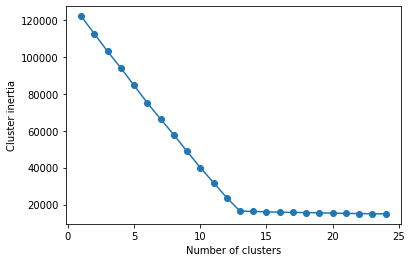

In [10]:
inertia = []
k_min=1
k_max=25
for i in range(k_min, k_max):
    print(i)
    km = KMeans(n_clusters=i,init='k-means++')
    km.fit(df_concat)
    inertia.append(km.inertia_)

plt.plot(range(k_min,k_max), inertia,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cluster inertia')
plt.show()

### Automatic with silhouette

For n_clusters = 13 The average silhouette_score is : 0.07726370736808


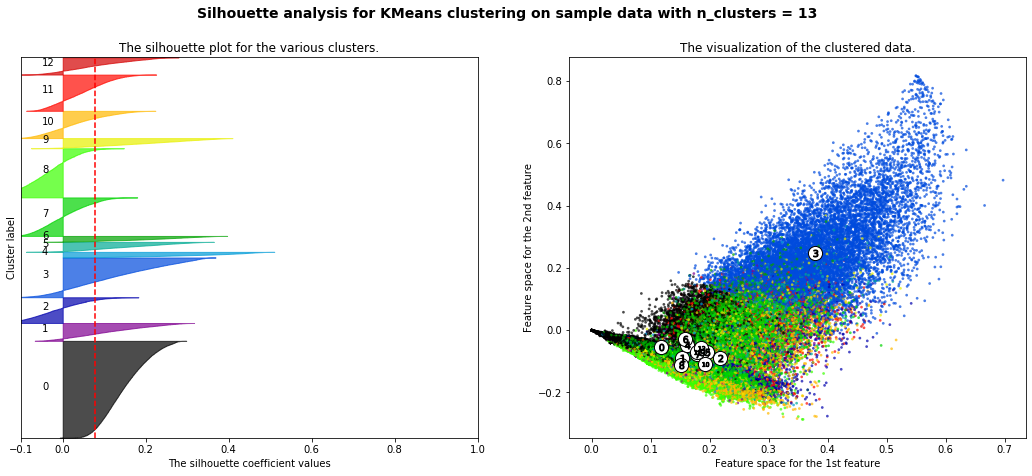

Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):


NameError: name 'kmeans' is not defined

In [15]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
range_n_clusters = [13]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(principal_components) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(principal_components)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(principal_components, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(principal_components, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(principal_components[:, 0], principal_components[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(df_concat))
